# ２０２２年の車上荒らしについて分析してみた。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=[19.2,10.8]
plt.rcParams['font.family']= 'Hiragino Maru Gothic Pro'

## 1. データクレンジング

In [2]:
#CSV読み込み
df1=pd.read_csv("tokyo_2022syazyounerai.csv")
df1.head()

,罪名,手口,管轄警察署（発生地）,管轄交番・駐在所（発生地）,市区町村コード（発生地）,都道府県（発生地）,市区町村（発生地）,町丁目（発生地）,発生年月日（始期）,発生時（始期）,発生場所,発生場所の詳細,施錠関係,現金被害の有無
0,窃盗,車上ねらい,中央,八重洲通交番,131024.0,東京都,中央区,八重洲１丁目,2022/7/9,11,道路上,その他,施錠せず,あり
1,窃盗,車上ねらい,中央,八重洲通交番,131024.0,東京都,中央区,八重洲２丁目,2022/4/3,11,道路上,その他,施錠せず,あり
2,窃盗,車上ねらい,中央,八重洲通交番,131024.0,東京都,中央区,八重洲２丁目,2022/4/3,13,駐車（輪）場,駐車（輪）場,施錠せず,なし
3,窃盗,車上ねらい,中央,八重洲通交番,131024.0,東京都,中央区,八重洲２丁目,2022/10/18,22,道路上,その他,施錠せず,あり
4,窃盗,車上ねらい,中央,日本橋交番,131024.0,東京都,中央区,日本橋２丁目,2022/1/3,14,道路上,その他,施錠せず,なし


In [3]:
#カラム削除(市区町村コード,町丁目)
df1=df1.drop(["市区町村コード（発生地）","町丁目（発生地）"],axis=1)
#年月日をdatetime型に変換
df1["発生年月日（始期）"]=pd.to_datetime(df1["発生年月日（始期）"])
df1.head()

,罪名,手口,管轄警察署（発生地）,管轄交番・駐在所（発生地）,都道府県（発生地）,市区町村（発生地）,発生年月日（始期）,発生時（始期）,発生場所,発生場所の詳細,施錠関係,現金被害の有無
0,窃盗,車上ねらい,中央,八重洲通交番,東京都,中央区,2022-07-09,11,道路上,その他,施錠せず,あり
1,窃盗,車上ねらい,中央,八重洲通交番,東京都,中央区,2022-04-03,11,道路上,その他,施錠せず,あり
2,窃盗,車上ねらい,中央,八重洲通交番,東京都,中央区,2022-04-03,13,駐車（輪）場,駐車（輪）場,施錠せず,なし
3,窃盗,車上ねらい,中央,八重洲通交番,東京都,中央区,2022-10-18,22,道路上,その他,施錠せず,あり
4,窃盗,車上ねらい,中央,日本橋交番,東京都,中央区,2022-01-03,14,道路上,その他,施錠せず,なし


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   罪名             1668 non-null   object        
 1   手口             1668 non-null   object        
 2   管轄警察署（発生地）     1668 non-null   object        
 3   管轄交番・駐在所（発生地）  1666 non-null   object        
 4   都道府県（発生地）      1667 non-null   object        
 5   市区町村（発生地）      1667 non-null   object        
 6   発生年月日（始期）      1668 non-null   datetime64[ns]
 7   発生時（始期）        1668 non-null   object        
 8   発生場所           1668 non-null   object        
 9   発生場所の詳細        1668 non-null   object        
 10  施錠関係           1668 non-null   object        
 11  現金被害の有無        1668 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 156.5+ KB


In [5]:
#欠損値確認
print(df1.isnull().sum())
#欠損値抽出
dfnull=df1[df1.isnull().any(axis=1)]
display(dfnull)

罪名               0
手口               0
管轄警察署（発生地）       0
管轄交番・駐在所（発生地）    2
都道府県（発生地）        1
市区町村（発生地）        1
発生年月日（始期）        0
発生時（始期）          0
発生場所             0
発生場所の詳細          0
施錠関係             0
現金被害の有無          0
dtype: int64


,罪名,手口,管轄警察署（発生地）,管轄交番・駐在所（発生地）,都道府県（発生地）,市区町村（発生地）,発生年月日（始期）,発生時（始期）,発生場所,発生場所の詳細,施錠関係,現金被害の有無
210,窃盗,車上ねらい,大森,NaN,東京都,大田区,2022-04-09,15,駐車（輪）場,駐車（輪）場,施錠した,あり
886,窃盗,車上ねらい,荒川,NaN,NaN,NaN,2022-10-29,16,道路上,その他,施錠せず,あり


In [6]:
#欠損値削除
df1=df1.dropna()
#発生時「不明」を削除して、int型に変換
df1=df1.drop(index=df1[df1["発生時（始期）"]=="不明"].index)
df1["発生時（始期）"]=df1["発生時（始期）"].astype(int)

In [7]:
#2022年に発生した事件のみ抽出
df1["発生年"]=df1["発生年月日（始期）"].dt.strftime("%Y")
df1=df1[df1["発生年"]=="2022"]
df1=df1.drop(columns="発生年")
df1["発生年月"]=df1["発生年月日（始期）"].dt.strftime("%Y%m")
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1582 entries, 0 to 1667
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   罪名             1582 non-null   object        
 1   手口             1582 non-null   object        
 2   管轄警察署（発生地）     1582 non-null   object        
 3   管轄交番・駐在所（発生地）  1582 non-null   object        
 4   都道府県（発生地）      1582 non-null   object        
 5   市区町村（発生地）      1582 non-null   object        
 6   発生年月日（始期）      1582 non-null   datetime64[ns]
 7   発生時（始期）        1582 non-null   int64         
 8   発生場所           1582 non-null   object        
 9   発生場所の詳細        1582 non-null   object        
 10  施錠関係           1582 non-null   object        
 11  現金被害の有無        1582 non-null   object        
 12  発生年月           1582 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 173.0+ KB


## 2.統計分析

In [8]:
#東京都内の各市区町村の犯罪発生件数
df_bar=df1.groupby("市区町村（発生地）").count()[["都道府県（発生地）"]]
df_bar=df_bar.sort_values("都道府県（発生地）",ascending=False)
df_bar.head()

,都道府県（発生地）
市区町村（発生地）,
大田区,141
江戸川区,129
板橋区,94
足立区,86
世田谷区,64


In [9]:
#平均・分散・標準偏差
print("都内の年間発生件数")
print("平均",df_bar["都道府県（発生地）"].mean())
print("分散",df_bar["都道府県（発生地）"].var())
print("標準偏差",df_bar["都道府県（発生地）"].std())

都内の年間発生件数
平均 31.019607843137255
分散 911.6596078431372
標準偏差 30.19370145979352


In [10]:
#ポアソン分布
from scipy.stats import skew,poisson,kurtosis

bar_mean=df_bar.mean()
x=np.arange(0,60,1)
#確率質量関数
poi=poisson.pmf(x,bar_mean)
#累積関数
cdf=poisson.cdf(x,bar_mean)
#尖度
sk=skew(poi)
#歪度
kur=kurtosis(poi)

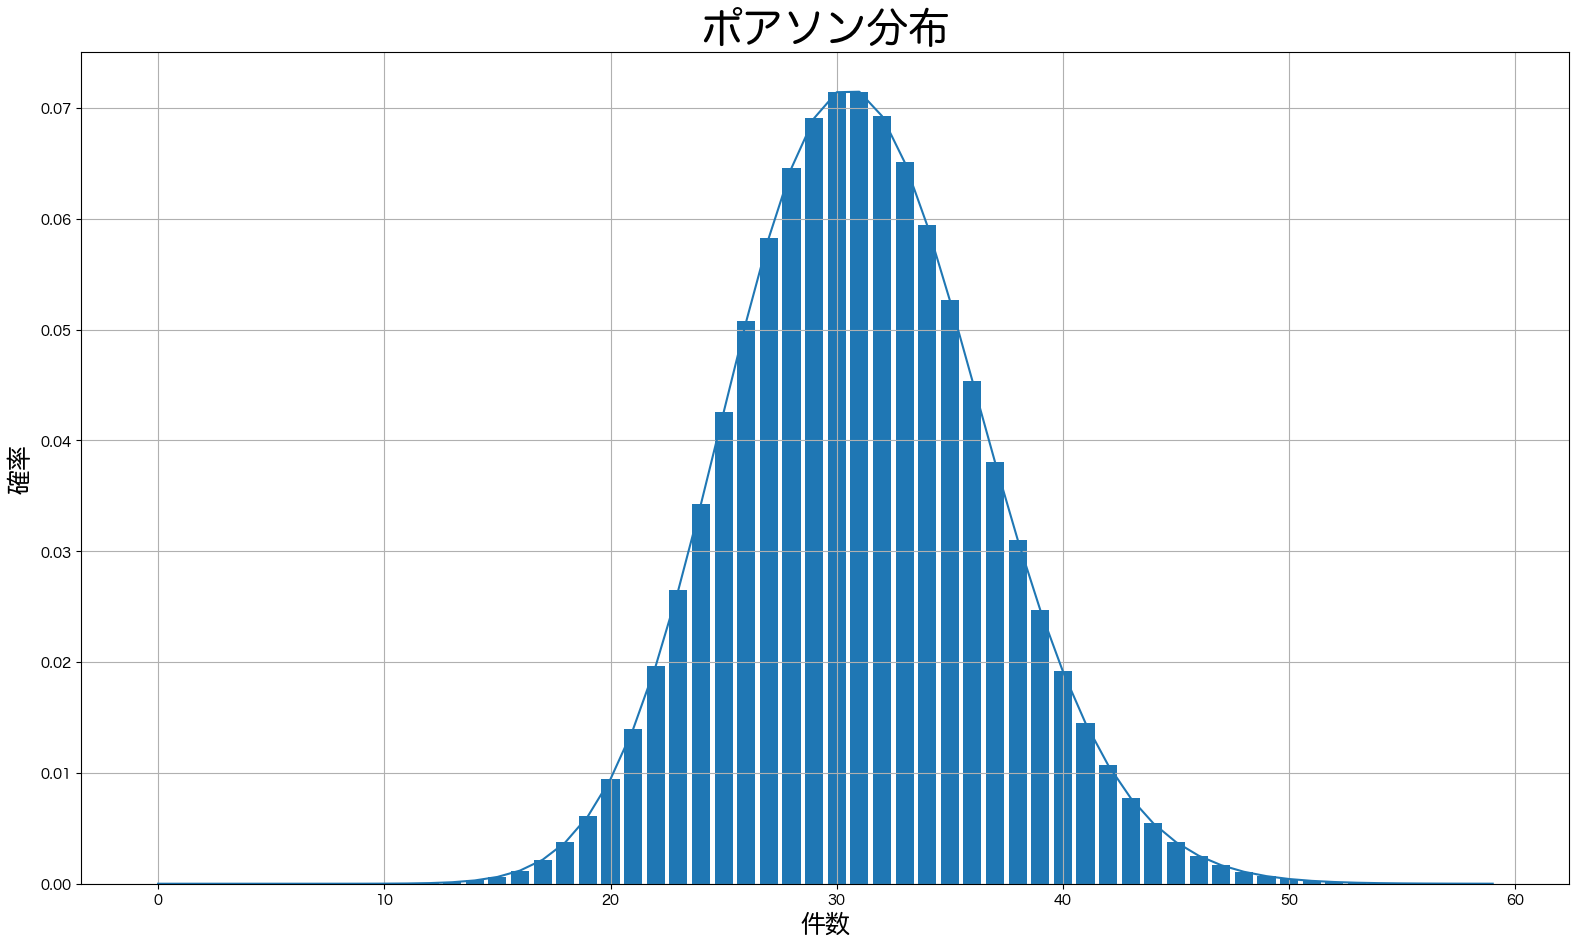

歪度: -0.05
尖度: 1.22


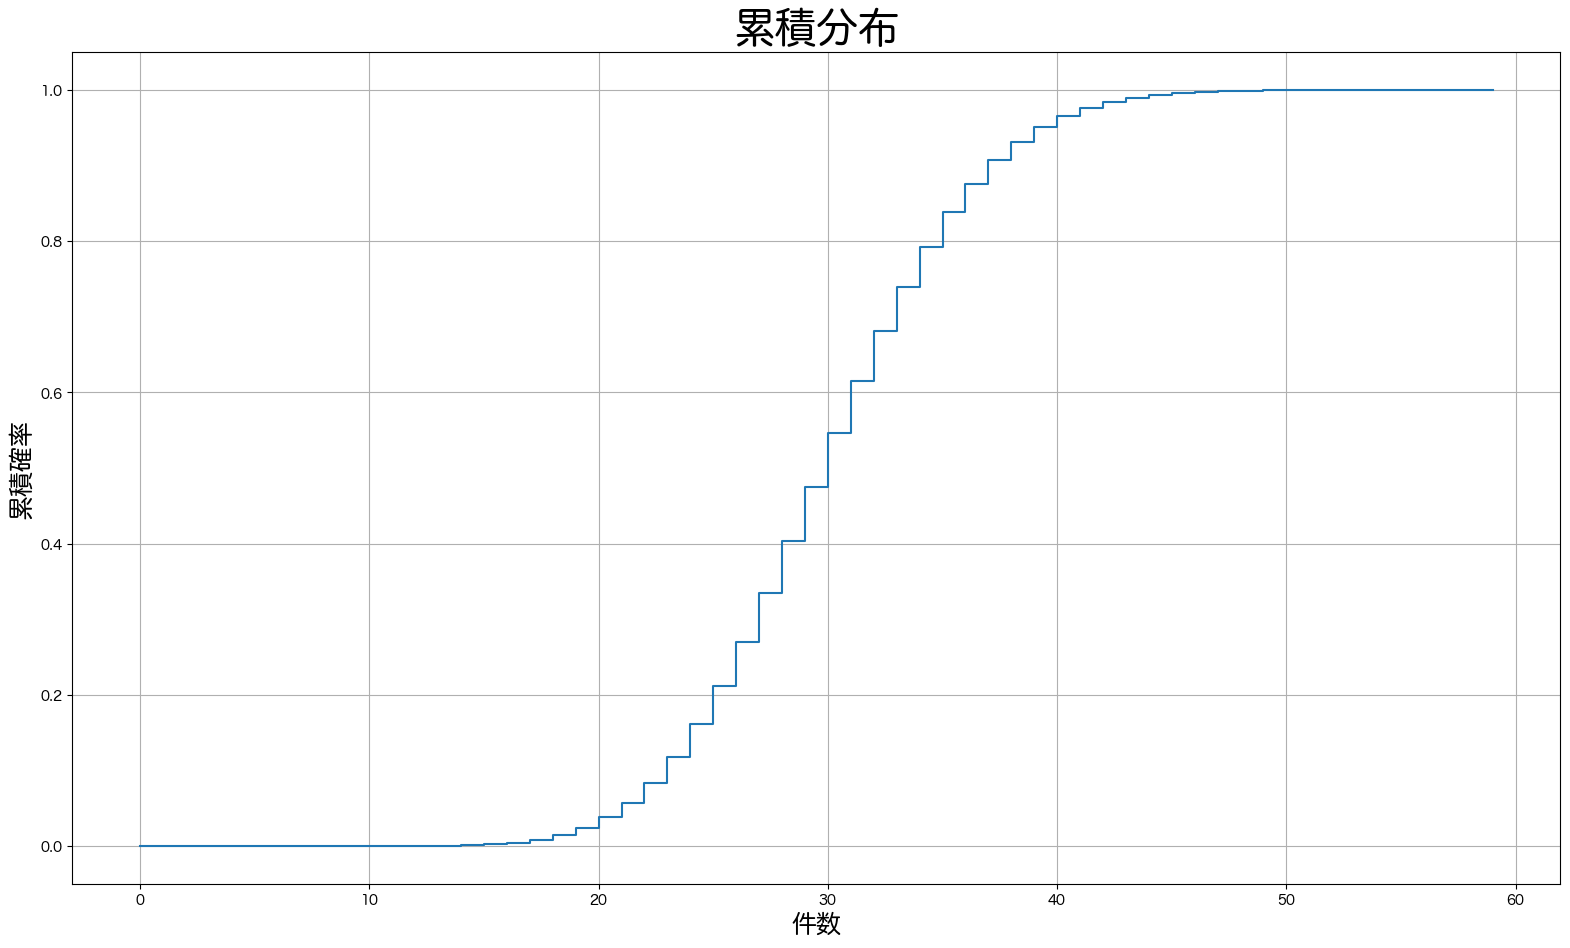

In [11]:
%matplotlib inline

plt.bar(x,poi)
plt.plot(x, poi)
plt.title("ポアソン分布",fontsize=30)
plt.xlabel("件数",fontsize=18)
plt.ylabel("確率",fontsize=18)
plt.grid()
plt.show()

print('歪度: {0:.2f}'.format(kur))
print('尖度: {0:.2f}'.format(sk))

#累積分布関数
%matplotlib inline

plt.title("累積分布",fontsize=30)
plt.step(x,cdf)
plt.xlabel("件数",fontsize=18)
plt.ylabel("累積確率",fontsize=18)
plt.grid()
plt.show()

## 自治体別統計データ

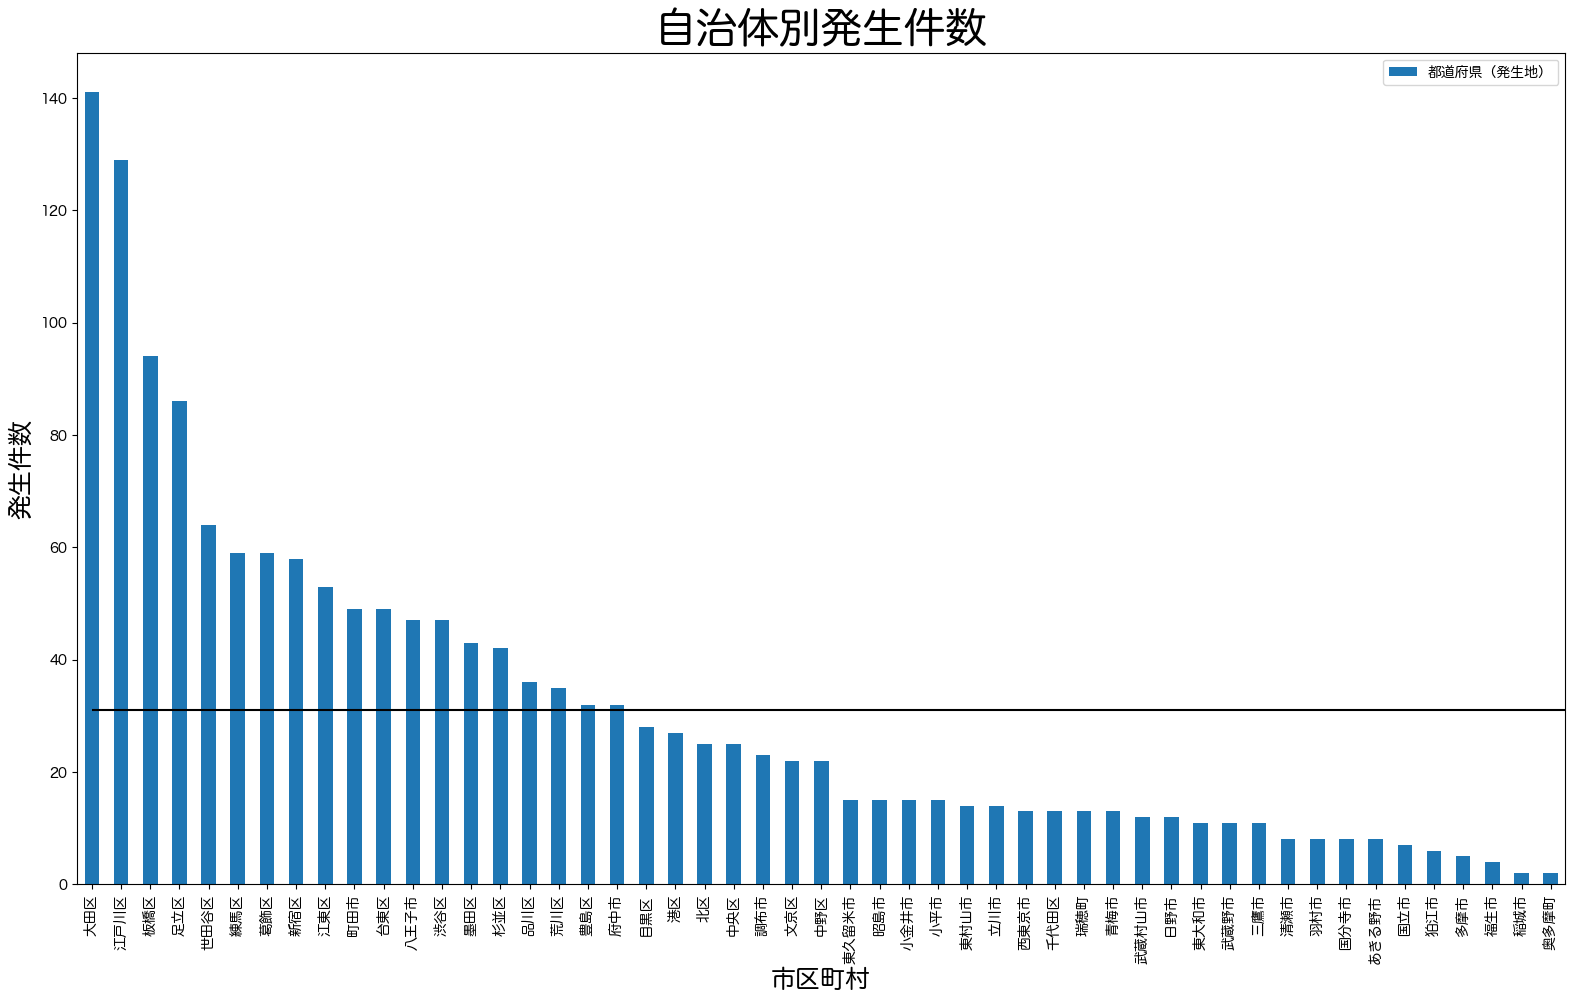

In [12]:
#グラフにプロット
df_bar.plot.bar()
plt.hlines(y=df_bar["都道府県（発生地）"].mean(),xmin=0,xmax=51,color="black")
plt.title("自治体別発生件数",fontsize=30)
plt.xlabel("市区町村",fontsize=18)
plt.ylabel("発生件数",fontsize=18)
plt.show()

In [13]:
#施錠の有無
df1.groupby(["施錠関係"]).count()[["発生年月日（始期）"]]

,発生年月日（始期）
施錠関係,
施錠した,224
施錠せず,1358


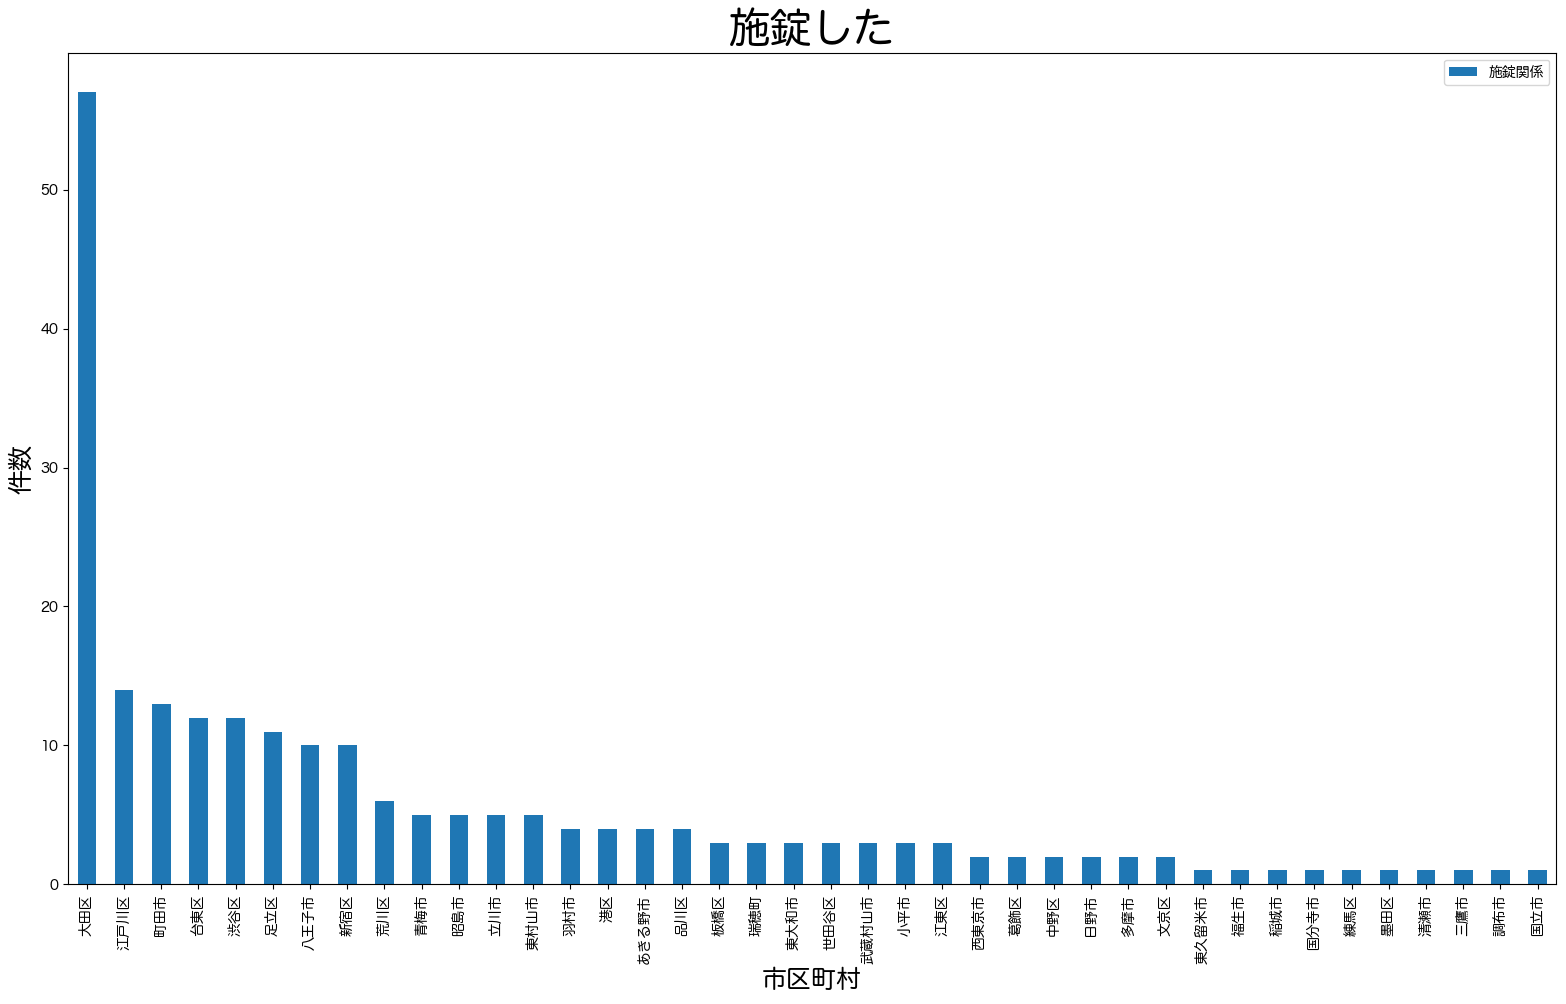

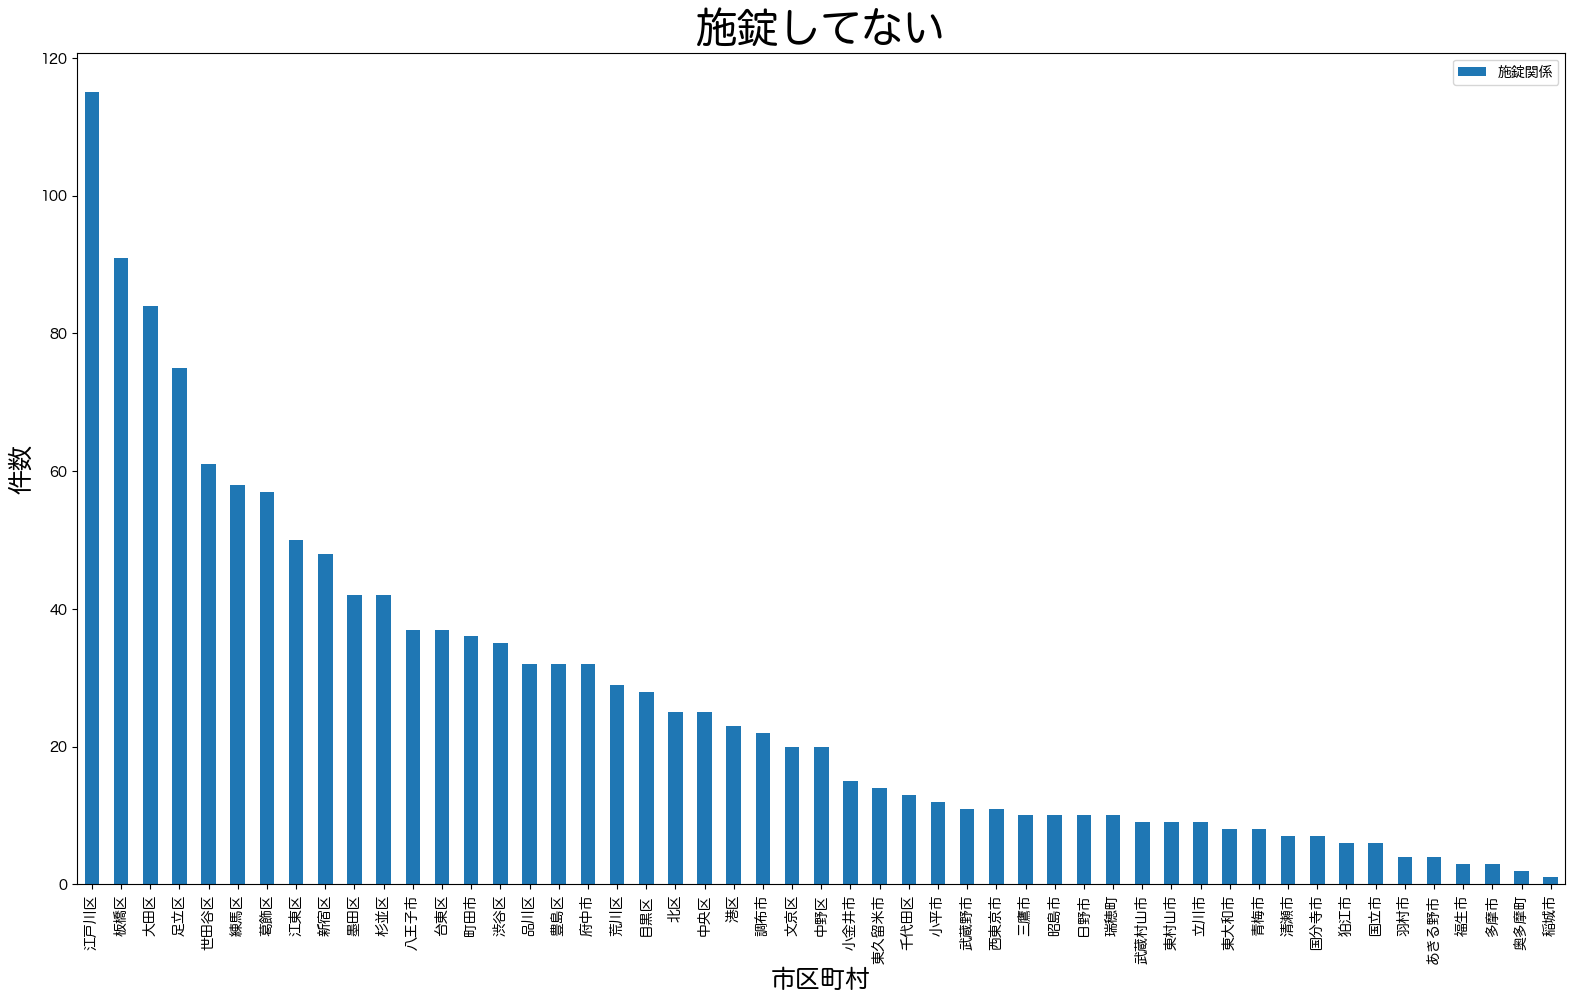

In [14]:
lock=df1[df1["施錠関係"]=="施錠した"]
lock=lock.groupby("市区町村（発生地）").count()[["施錠関係"]]
lock=lock.sort_values("施錠関係",ascending=False)

lock.plot.bar()
plt.title("施錠した",fontsize=30)
plt.xlabel("市区町村",fontsize=18)
plt.ylabel("件数",fontsize=18)
plt.show()

no_lock=df1[df1["施錠関係"]=="施錠せず"]
no_lock=no_lock.groupby("市区町村（発生地）").count()[["施錠関係"]]
no_lock=no_lock.sort_values("施錠関係",ascending=False)

no_lock.plot.bar()
plt.title("施錠してない",fontsize=30)
plt.xlabel("市区町村",fontsize=18)
plt.ylabel("件数",fontsize=18)
plt.show()

In [15]:
#現金被害の有無
df1.groupby(["現金被害の有無"]).count()[["発生年月日（始期）"]]

,発生年月日（始期）
現金被害の有無,
あり,716
なし,866


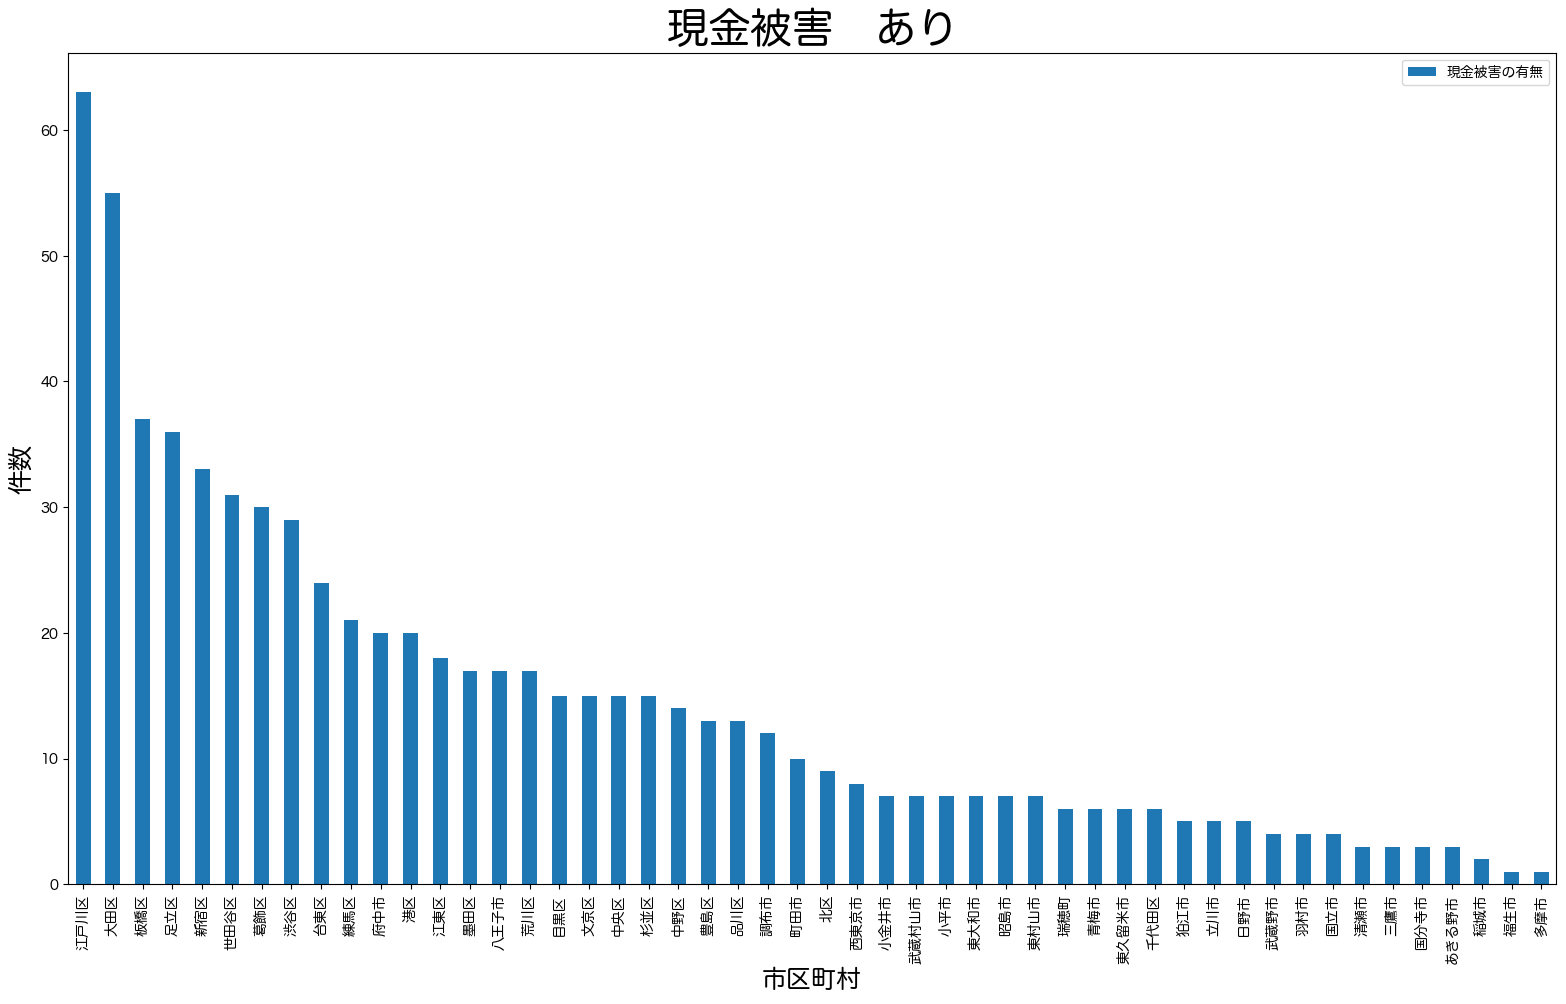

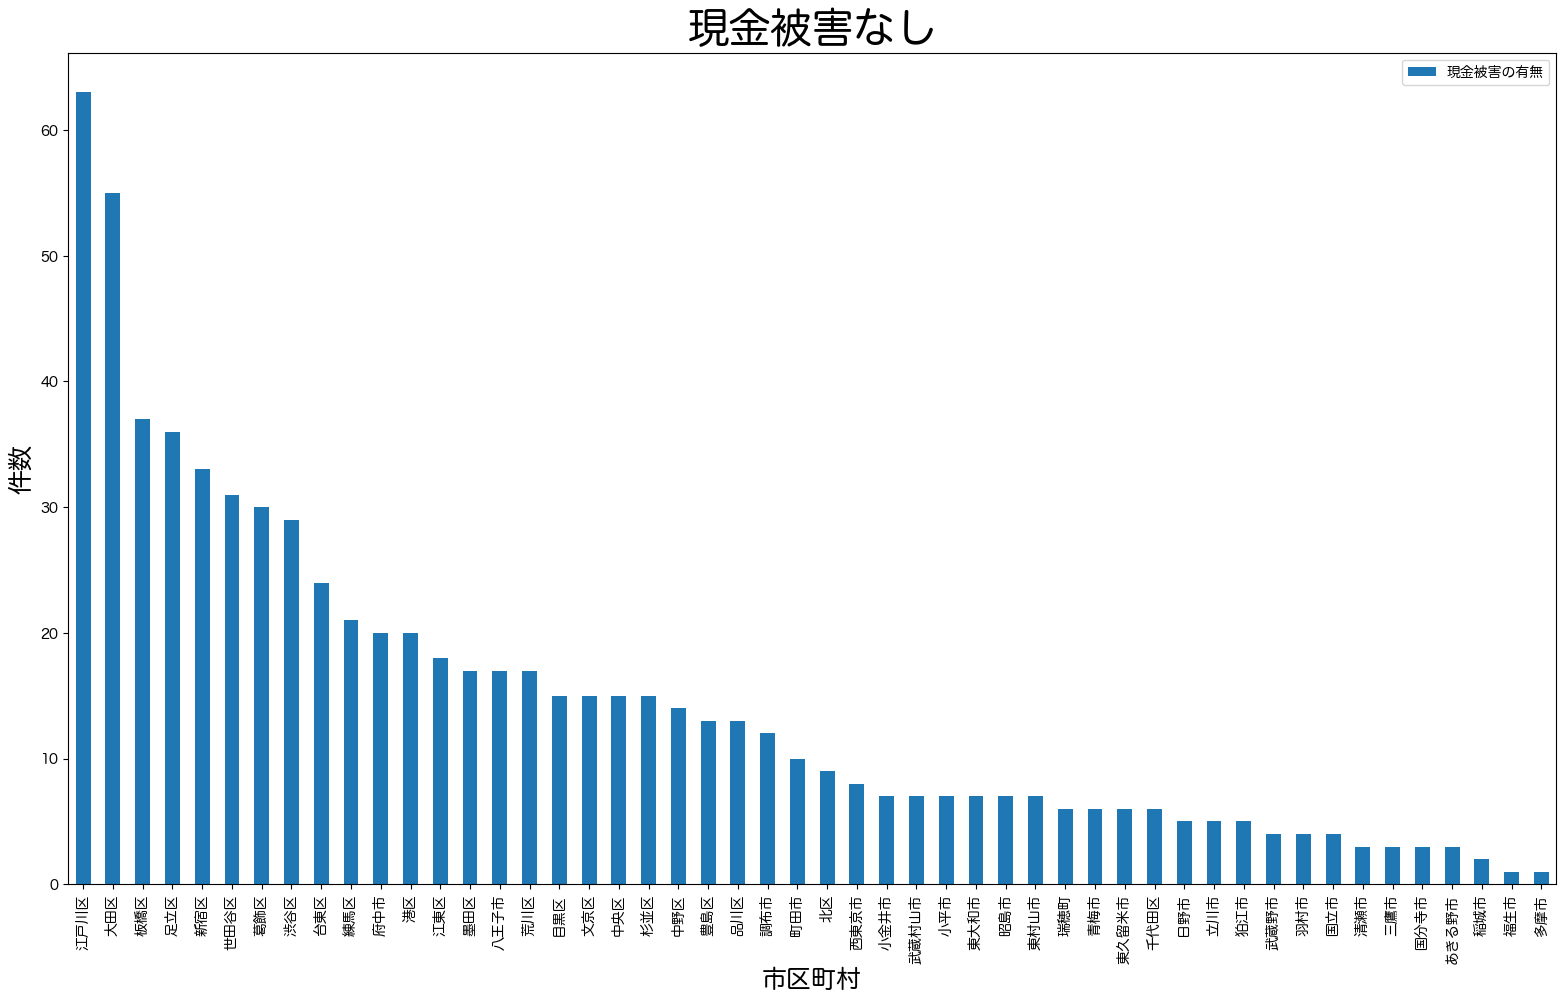

In [16]:
no_money=df1[df1["現金被害の有無"]=="あり"]
no_money=no_money.groupby("市区町村（発生地）").count()[["現金被害の有無"]]
no_money=no_money.sort_values("現金被害の有無",ascending=False)


no_money.plot.bar()
plt.title("現金被害　あり",fontsize=30)
plt.xlabel("市区町村",fontsize=18)
plt.ylabel("件数",fontsize=18)
plt.show()

money=df1[df1["現金被害の有無"]=="なし"]
money=no_money.groupby("市区町村（発生地）").count()[["現金被害の有無"]]
money=no_money.sort_values("現金被害の有無",ascending=False)

money.plot.bar()
plt.title("現金被害なし",fontsize=30)
plt.xlabel("市区町村",fontsize=18)
plt.ylabel("件数",fontsize=18)
plt.show()

In [17]:
df1.groupby(["発生年月","施錠関係","現金被害の有無"]).count()[["市区町村（発生地）"]]

市区町村（発生地）
発生年月   施錠関係 現金被害の有無           
202201 施錠した あり              14
            なし              12
       施錠せず あり              61
            なし              59
202202 施錠した あり               9
            なし               9
       施錠せず あり              41
            なし              52
202203 施錠した あり               5
            なし               6
       施錠せず あり              48
            なし              62
202204 施錠した あり              20
            なし              25
       施錠せず あり              50
            なし              54
202205 施錠した あり              15
            なし              25
       施錠せず あり              61
            なし              76
202206 施錠した あり               4
            なし              12
       施錠せず あり              52
            なし              67
202207 施錠した あり               2
            なし              11
       施錠せず あり              48
            なし              59
202208 施錠した あり               4
            なし               4
       施錠せず あり              47
            なし              52
202209 施錠した あり               9
            なし               1
       施錠せず あり              57
            なし              75
202210 施錠した あり               6
            なし              13
       施錠せず あり              61
            なし              60
202211 施錠した あり               1
            なし               7
       施錠せず あり              56
            なし              75
202212 施錠した あり               4
            なし               6
       施錠せず あり              41
            なし              44

In [18]:
#施錠したかつ現金被害ありのデータ抽出
brutal=df1[df1["現金被害の有無"]=="あり"]
brutal=brutal[brutal["施錠関係"]=="施錠した"]
brutal=brutal.groupby(["市区町村（発生地）"]).count()[["発生年月日（始期）"]]
brutal=brutal.sort_values("発生年月日（始期）",ascending=False)
display(brutal.head())
display("合計",brutal.sum())
display("平均",brutal.mean())

,発生年月日（始期）
市区町村（発生地）,
大田区,20
渋谷区,9
江戸川区,7
新宿区,6
足立区,4


'合計'

発生年月日（始期）    93
dtype: int64

'平均'

発生年月日（始期）    2.818182
dtype: float64

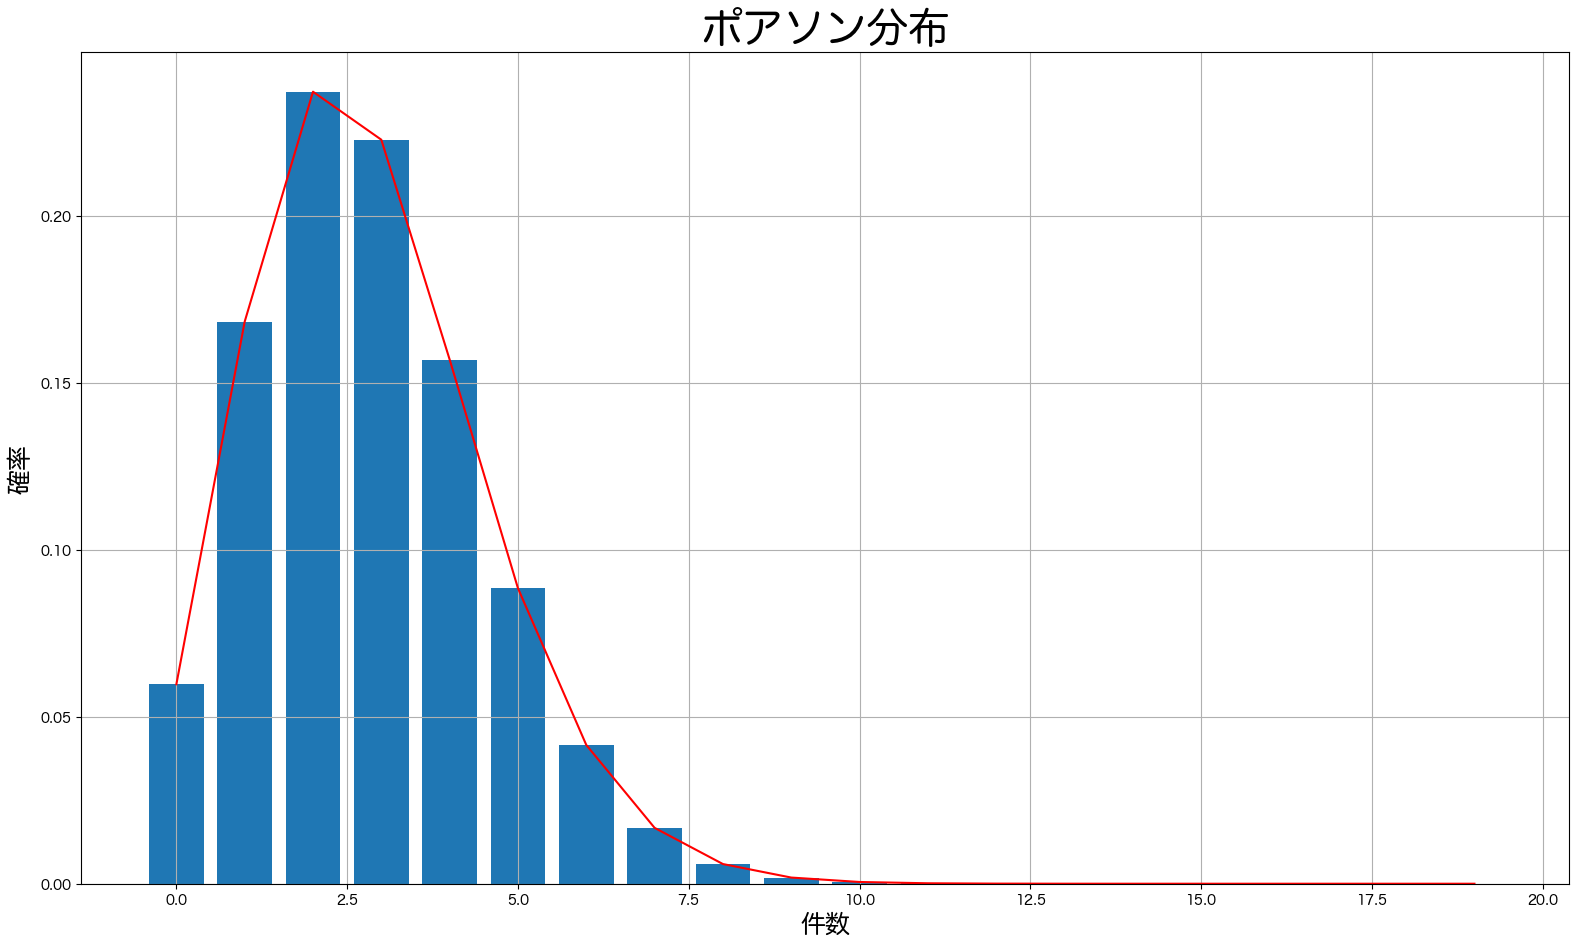

In [19]:
#ポアソン分布
from scipy.stats import poisson
brutal_mean=brutal.mean()
x=np.arange(0,20,1)
#確率質量関数
b_poi=poisson.pmf(x,brutal_mean)
#累積関数
cdf=poisson.cdf(x,brutal_mean)

plt.bar(x,b_poi)
plt.plot(x, b_poi,color="red")
plt.title("ポアソン分布",fontsize=30)
plt.xlabel("件数",fontsize=18)
plt.ylabel("確率",fontsize=18)
plt.grid()
plt.show()

In [20]:
#月単位で件数を抽出
df1["発生年月"] = df1["発生年月日（始期）"].dt.strftime("%Y%m")
df_month=df1.groupby(["発生年月"]).count()[["市区町村（発生地）"]]
df_month.head()

,市区町村（発生地）
発生年月,
202201,146
202202,111
202203,121
202204,149
202205,177


<StemContainer object of 3 artists>

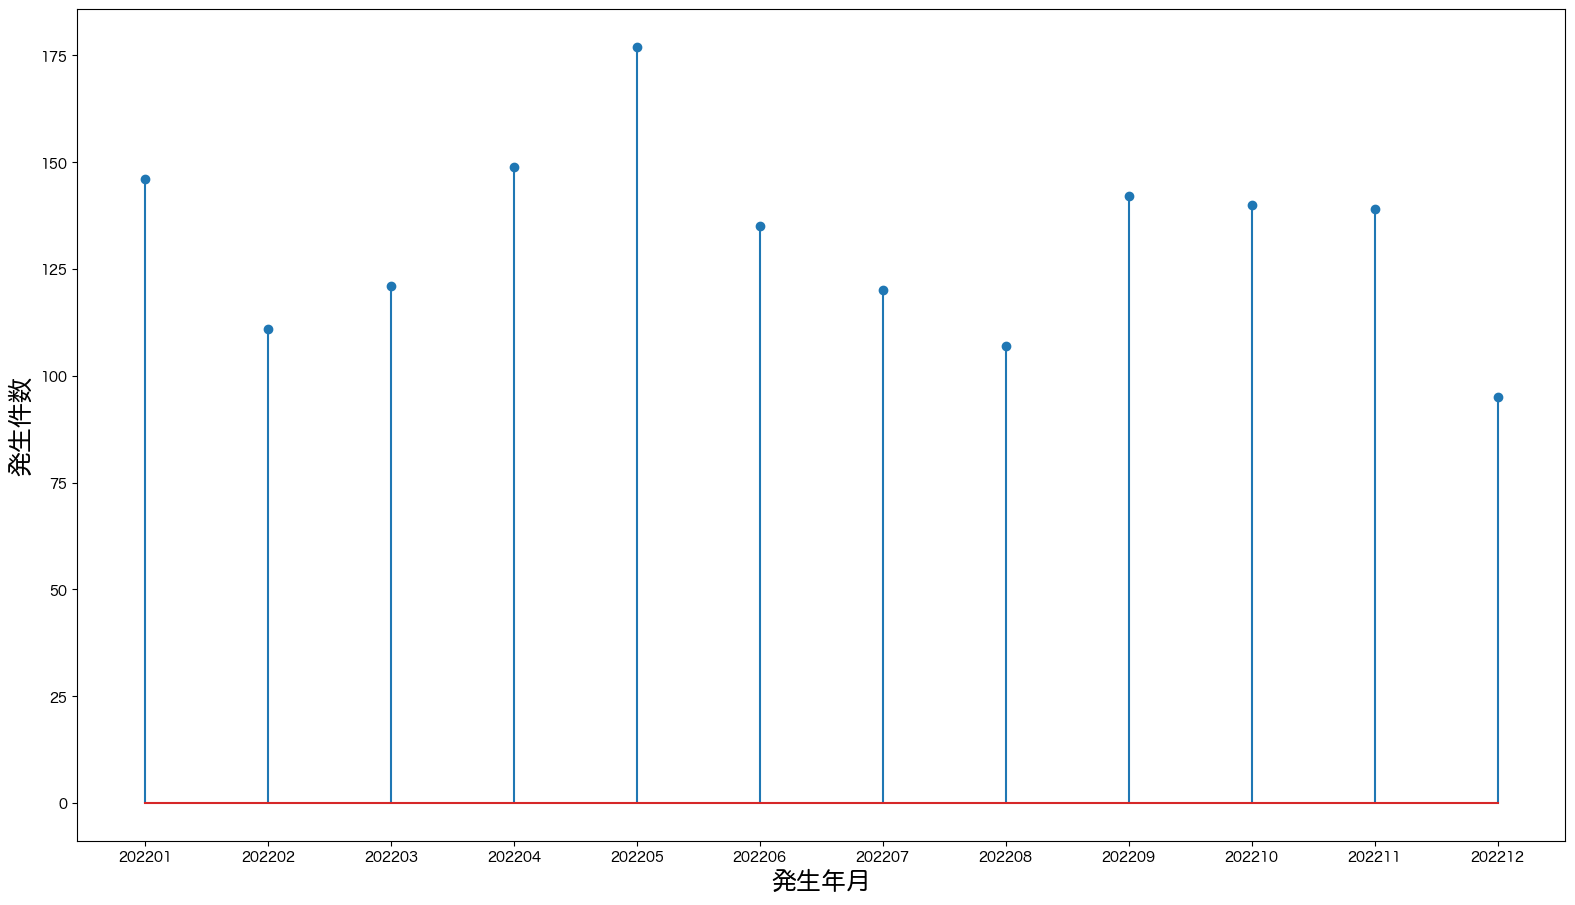

In [21]:
#コレログラム
%matplotlib inline

plt.xlabel("発生年月",fontsize=18)
plt.ylabel("発生件数",fontsize=18)
plt.stem(np.sort(df1["発生年月"].unique()),df_month)

In [22]:
#ロジスティック回帰(施錠関係の有無)
from sklearn.linear_model import LogisticRegression

logistic_x=np.array([df1["発生時（始期）"]]).reshape(-1, 1)
logistic_ylock=df1["施錠関係"].map({"施錠した":0,"施錠せず":1})
logistic_regression=LogisticRegression()
logistic_lock=logistic_regression.fit(logistic_x,logistic_ylock)

In [23]:
#性能評価
from sklearn.metrics import log_loss

lock_proba=logistic_lock.predict_proba(logistic_x)
score=log_loss(logistic_ylock,lock_proba)
print(lock_proba)
print(f'logloss:{score:.4f}')

[[0.1048537  0.8951463 ]
 [0.1048537  0.8951463 ]
 [0.12180644 0.87819356]
 ...
 [0.09001855 0.90998145]
 [0.1048537  0.8951463 ]
 [0.187175   0.812825  ]]
logloss:0.3976


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       224
           1       0.86      1.00      0.92      1358

    accuracy                           0.86      1582
   macro avg       0.43      0.50      0.46      1582
weighted avg       0.74      0.86      0.79      1582



/Users/isonotakashimakoto/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isonotakashimakoto/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isonotakashimakoto/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

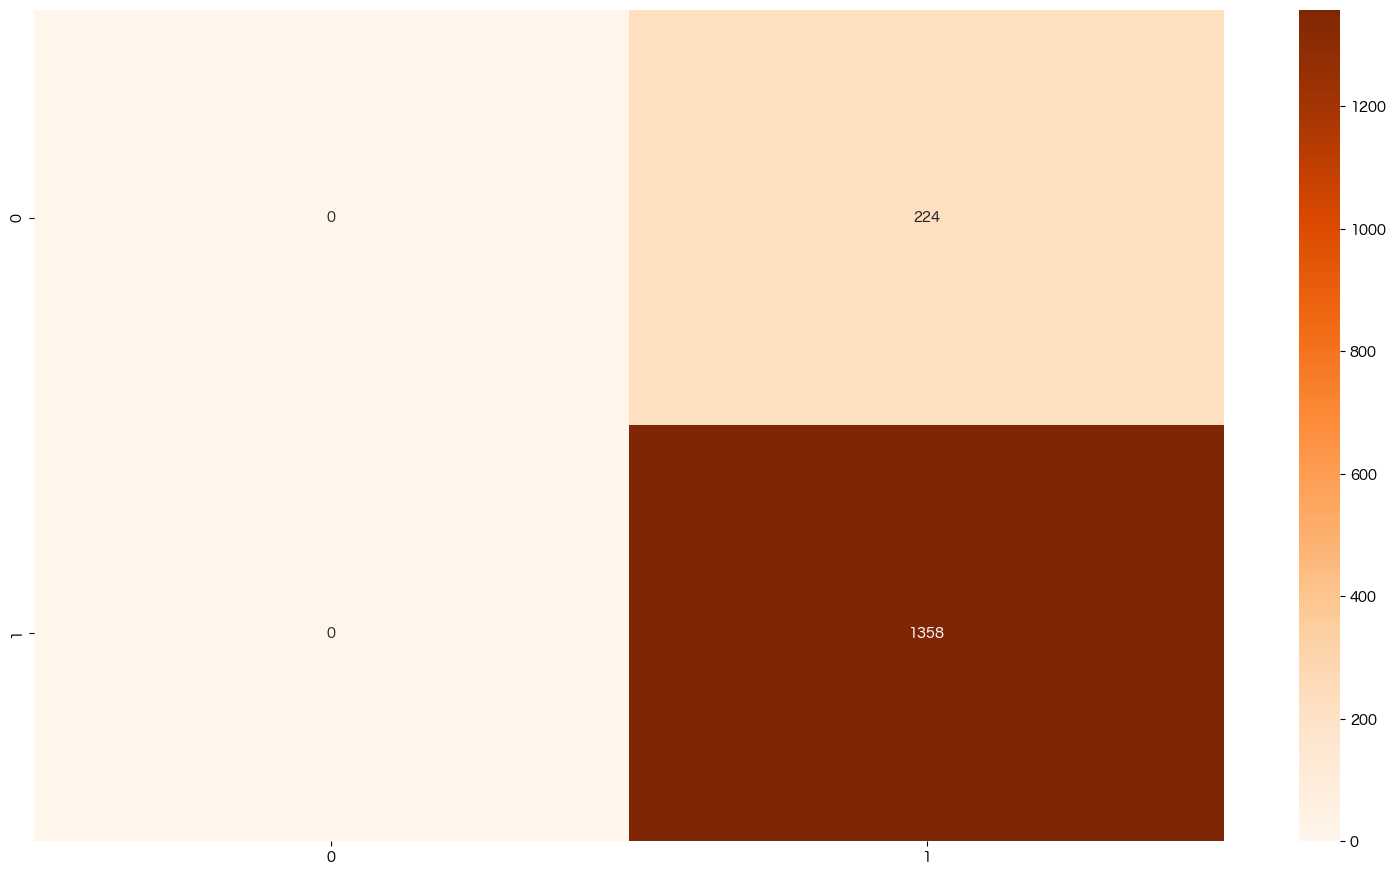

In [24]:
#混同行列
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

lock_pred=logistic_lock.predict(logistic_x)
lock_cm=confusion_matrix(logistic_ylock,lock_pred)
sns.heatmap(lock_cm,annot=True,cmap='Oranges',fmt='d')
print(classification_report(logistic_ylock,lock_pred))

In [25]:
df1.groupby(["現金被害の有無"]).count()[["発生年月日（始期）"]]

,発生年月日（始期）
現金被害の有無,
あり,716
なし,866


In [26]:
#ロジスティック回帰(現金被害のの有無)
logistic_ymoney=df1["現金被害の有無"].map({"あり":0,"なし":1})
logistic_money=logistic_regression.fit(logistic_x,logistic_ymoney)

In [27]:
#性能評価
from sklearn.metrics import log_loss

money_proba=logistic_money.predict_proba(logistic_x)
score=log_loss(logistic_ymoney,money_proba)
print(money_proba)
print(f'logloss:{score:.4f}')

[[0.4721048  0.5278952 ]
 [0.4721048  0.5278952 ]
 [0.45999274 0.54000726]
 ...
 [0.48424978 0.51575022]
 [0.4721048  0.5278952 ]
 [0.42399441 0.57600559]]
logloss:0.6866


              precision    recall  f1-score   support

           0       0.48      0.08      0.14       716
           1       0.55      0.93      0.69       866

    accuracy                           0.54      1582
   macro avg       0.51      0.50      0.41      1582
weighted avg       0.52      0.54      0.44      1582



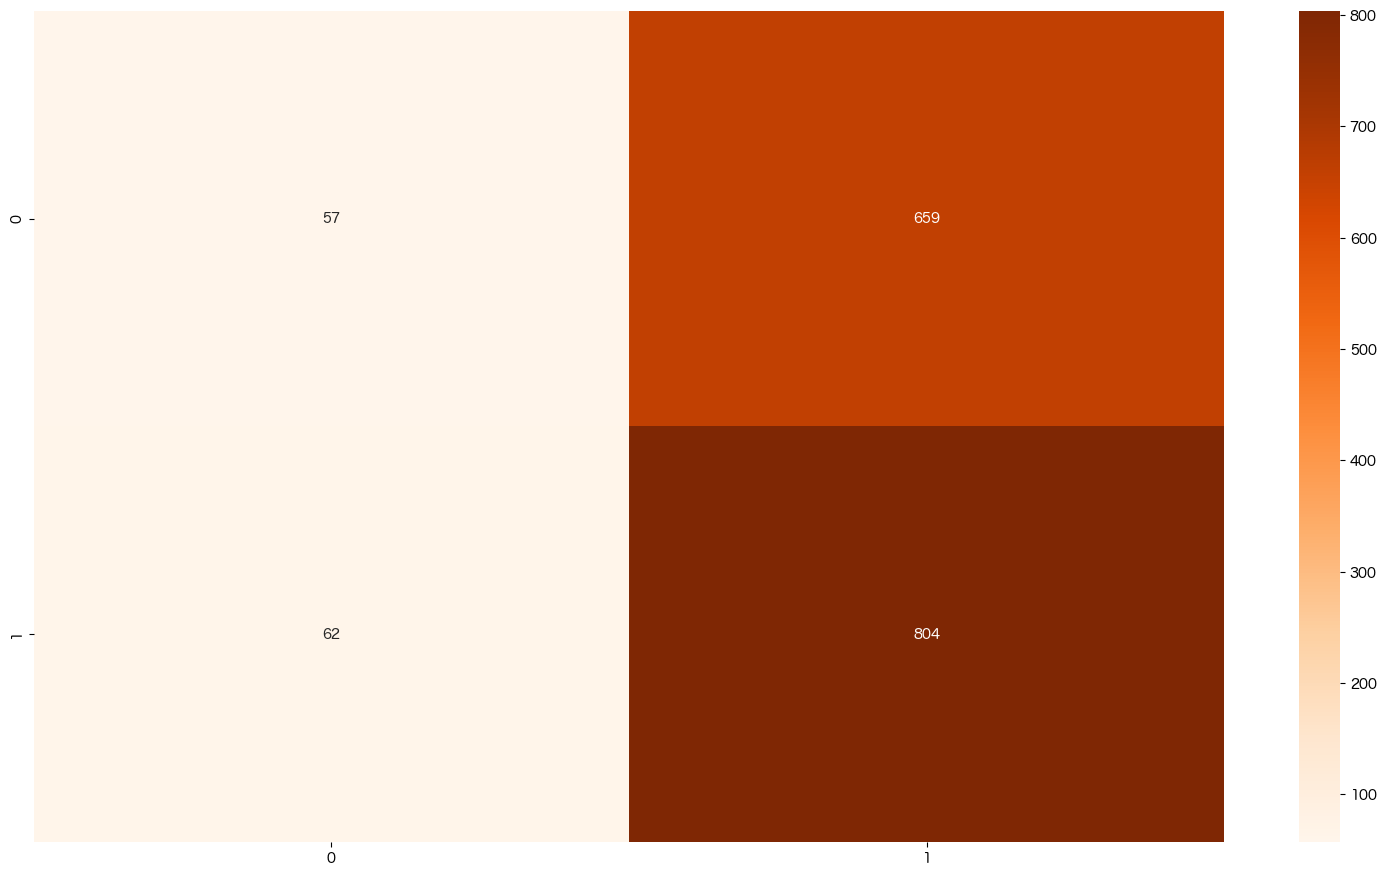

In [28]:
#混同行列
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

money_pred=logistic_money.predict(logistic_x)
money_cm=confusion_matrix(logistic_ymoney,money_pred)
sns.heatmap(money_cm,annot=True,cmap='Oranges',fmt='d')
print(classification_report(logistic_ymoney,money_pred))

## 3. 人口と犯罪発生件数についての予測モデル

In [29]:
population=pd.read_csv("jy22qv0100.csv")
population.head()

,地域階層,地域コード,地域,令和4年1月1日現在／世帯数(世帯),令和4年1月1日現在／人口／総数(人),令和4年1月1日現在／人口／男(人),令和4年1月1日現在／人口／女(人),人口密度1km2につき（令和4年）(人/km2),令和3年1月1日現在／世帯数(世帯),令和3年1月1日現在／人口／総数(人),令和3年1月1日現在／人口／男(人),令和3年1月1日現在／人口／女(人),差引増減人口（人口総数）(人),増減率 (人口総数)(%)
0,0,13000.0,総数,7354402.0,13794933.0,6775557.0,7019376.0,6287.0,7341487.0,13843525.0,6805319.0,7038206.0,-48592.0,-0.35
1,1,13100.0,区部,5254558.0,9522872.0,4669453.0,4853419.0,15175.0,5258484.0,9572763.0,4698055.0,4874708.0,-49891.0,-0.52
2,4,13101.0,千代田区,37773.0,67049.0,33485.0,33564.0,5750.0,37787.0,67216.0,33698.0,33518.0,-167.0,-0.25
3,4,13102.0,中央区,96535.0,171419.0,81477.0,89942.0,16789.0,95812.0,170583.0,81287.0,89296.0,836.0,0.49
4,4,13103.0,港区,145951.0,257183.0,120947.0,136236.0,12626.0,146527.0,259036.0,122111.0,136925.0,-1853.0,-0.72


In [30]:
population.isnull().sum()
population_null=population[population.isnull().any(axis=1)]
population_null

,地域階層,地域コード,地域,令和4年1月1日現在／世帯数(世帯),令和4年1月1日現在／人口／総数(人),令和4年1月1日現在／人口／男(人),令和4年1月1日現在／人口／女(人),人口密度1km2につき（令和4年）(人/km2),令和3年1月1日現在／世帯数(世帯),令和3年1月1日現在／人口／総数(人),令和3年1月1日現在／人口／男(人),令和3年1月1日現在／人口／女(人),差引増減人口（人口総数）(人),増減率 (人口総数)(%)
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,住民基本台帳による東京都の世帯と人口 令和4年1月,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,第１表 区市町村、世帯数、男女別人口（人口総数）及び人口密度（令和4、3年）,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,注）「世帯数」は、日本人のみの世帯、外国人のみの世帯及び日本人と外国人の複数国籍世帯を合わせ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,地域階層（0:総数 1:区部・市部・町村部 2:郡部・島部 3:大島支庁・三宅支庁・八丈支庁...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#欠損値削除
population=population.dropna()
population=population.drop(population.index[[0,1]])
#空白削除
population["地域"]=population["地域"].str.strip()
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 2 to 71
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   地域階層                      70 non-null     object 
 1   地域コード                     70 non-null     float64
 2   地域                        70 non-null     object 
 3   令和4年1月1日現在／世帯数(世帯)        70 non-null     float64
 4   令和4年1月1日現在／人口／総数(人)       70 non-null     float64
 5   令和4年1月1日現在／人口／男(人)        70 non-null     float64
 6   令和4年1月1日現在／人口／女(人)        70 non-null     float64
 7   人口密度1km2につき（令和4年）(人/km2)  70 non-null     float64
 8   令和3年1月1日現在／世帯数(世帯)        70 non-null     float64
 9   令和3年1月1日現在／人口／総数(人)       70 non-null     float64
 10  令和3年1月1日現在／人口／男(人)        70 non-null     float64
 11  令和3年1月1日現在／人口／女(人)        70 non-null     float64
 12  差引増減人口（人口総数）(人)           70 non-null     float64
 13  増減率 (人口総数)(%)             70 non-null     float64
dtypes: float64(1

In [32]:
population_num=population[["地域","令和4年1月1日現在／人口／総数(人)",]]
population_num.head()

,地域,令和4年1月1日現在／人口／総数(人)
2,千代田区,67049.0
3,中央区,171419.0
4,港区,257183.0
5,新宿区,341222.0
6,文京区,226332.0


In [33]:
#データ統合
df_new=df_bar.reset_index()
df_new=df_new.rename(columns={'市区町村（発生地）': '地域'})
df_pop=pd.merge(df_new,population_num,on='地域',how='left')
df_pop.head()

,地域,都道府県（発生地）,令和4年1月1日現在／人口／総数(人)
0,大田区,141,728703.0
1,江戸川区,129,689739.0
2,板橋区,94,567214.0
3,足立区,86,689106.0
4,世田谷区,64,916208.0


In [34]:
#欠損値確認
df_pop.isnull().sum()

地域                     0
都道府県（発生地）              0
令和4年1月1日現在／人口／総数(人)    0
dtype: int64

In [35]:
#正規化
from sklearn.preprocessing import MinMaxScaler

mm=MinMaxScaler()
df_mm=mm.fit_transform(df_pop[["都道府県（発生地）","令和4年1月1日現在／人口／総数(人)"]])

#標準化
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
df_sc=sc.fit_transform(df_mm)
df_sc=pd.DataFrame(df_mm)
df_sc.head()

,0,1
0,1.000000,0.794247
1,0.913669,0.751491
2,0.661871,0.617042
3,0.604317,0.750796
4,0.446043,1.000000


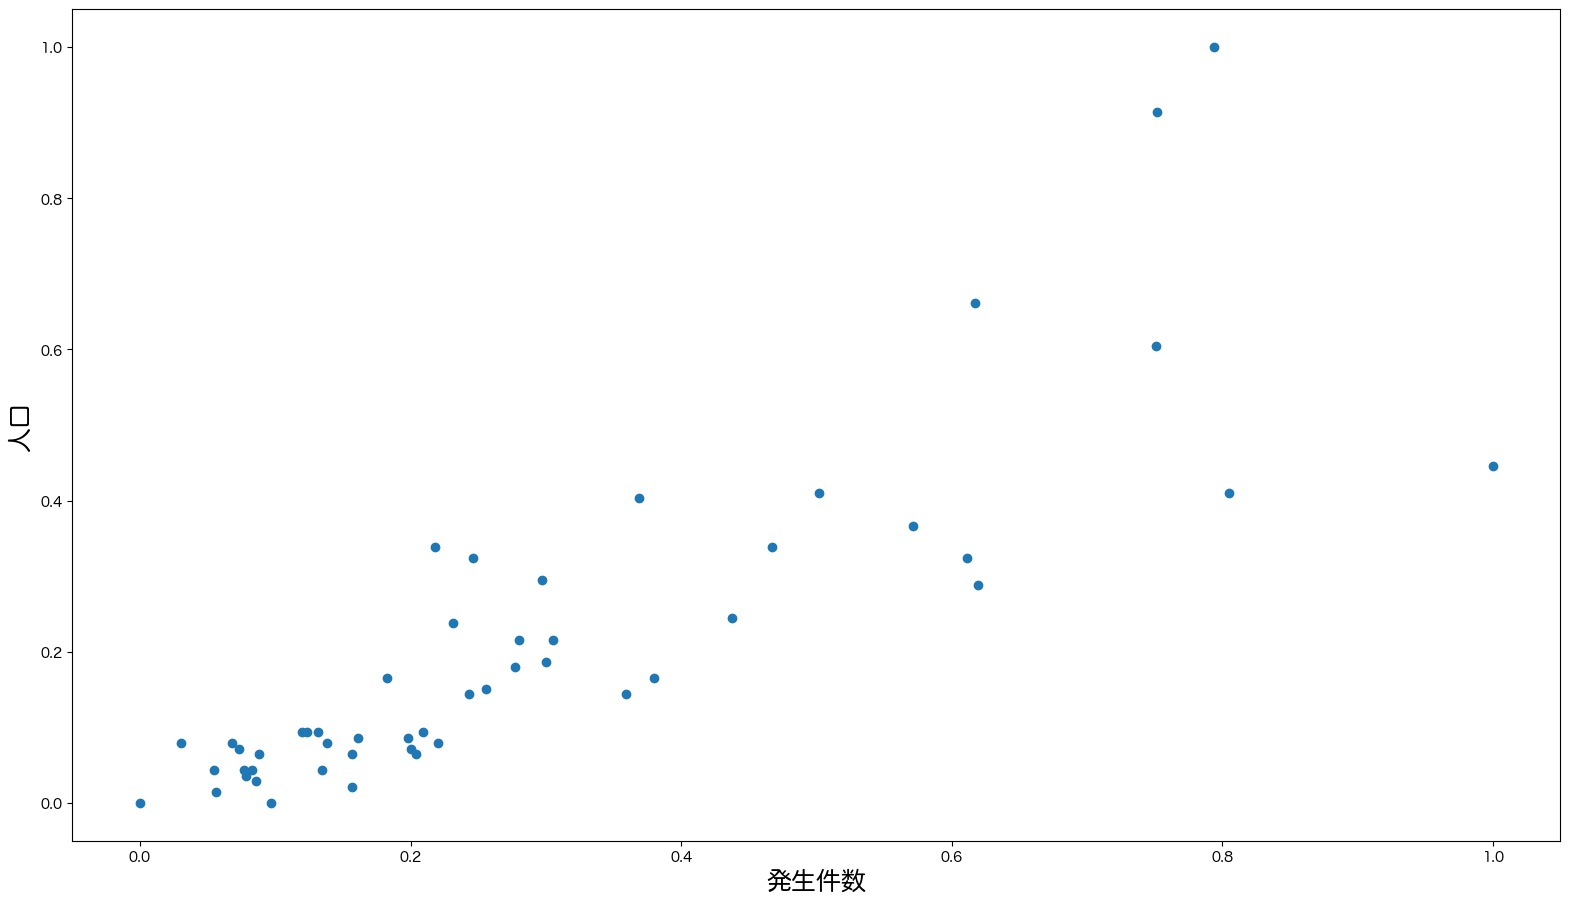

In [36]:
#散布図
%matplotlib inline
plt.scatter(df_sc[1],df_sc[0])
plt.xlabel("発生件数",fontsize=18)
plt.ylabel("人口",fontsize=18)
plt.show()

In [37]:
#線形単回帰
from sklearn.linear_model import LinearRegression

linear_regression=LinearRegression()
x=np.array(df_sc[0]).reshape(-1, 1)
y=np.array(df_sc[1]).reshape(-1, 1)
linear_reg=linear_regression.fit(x,y)
print("回帰係数：",linear_reg.coef_,"切片：",linear_reg.intercept_)
linear_pred=linear_reg.predict(x)
print("決定係数：",linear_regression.score(x, y))

回帰係数： [[0.92094976]] 切片： [0.09823999]
決定係数： 0.7102136839033042


In [38]:
#多項式回帰
from sklearn.preprocessing import PolynomialFeatures

#バイアス削除
quadratic=PolynomialFeatures(degree=2,include_bias=False)
x_quad=quadratic.fit_transform(x)
poly_reg=linear_regression.fit(x_quad,y)
print("回帰係数：",poly_reg.coef_,"切片：",poly_reg.intercept_)
poly_pred=poly_reg.predict(x_quad)
print("決定係数：",linear_regression.score(x_quad, y))

回帰係数： [[ 1.67980161 -0.92270124]] 切片： [0.02271268]
決定係数： 0.7811654451674164


In [39]:
#リッジ回帰
from sklearn.linear_model import Ridge

ridge_regression=Ridge(alpha=0.1)
ridge_reg=ridge_regression.fit(x_quad,y)
print("回帰係数：",ridge_reg.coef_,"切片：",ridge_reg.intercept_)
ridge_pred=ridge_reg.predict(x_quad)
print("決定係数：",ridge_regression.score(x_quad, y))

回帰係数： [[ 1.16773423 -0.36025271]] 切片： [0.07908516]
決定係数： 0.7527502936013795


In [40]:
#線形サポートベクター回帰
from sklearn.svm import SVR

svr=SVR(kernel='linear')
svr_reg=svr.fit(x,y.ravel())
print("回帰係数：",svr_reg.coef_,"切片：",svr_reg.intercept_)
svr_pred=svr_reg.predict(x)
print("決定係数：",svr.score(x, y))

回帰係数： [[0.78132086]] 切片： [0.13762226]
決定係数： 0.6919932558661401


In [41]:
#多項式サポートベクター回帰

svr_poly=SVR(kernel='poly')
svr_polyreg=svr_poly.fit(x,y.ravel())
svr_poly_pred=svr_polyreg.predict(x)
print("決定係数：",svr_poly.score(x, y))

決定係数： 0.3016820030813726


In [42]:
#ガウスカーネルサポートベクター回帰

svr_rbf=SVR(kernel='rbf')
svr_rbfreg=svr_rbf.fit(x,y.ravel())
svr_rbf_pred=svr_rbfreg.predict(x)
print("決定係数：",svr_rbf.score(x, y))

決定係数： 0.8028452743196508


In [43]:
#決定木回帰
from sklearn.tree import DecisionTreeRegressor

tree_regression=DecisionTreeRegressor(max_depth=3)
tree_reg=tree_regression.fit(x, y)
tree_pred=tree_reg.predict(x)
print("決定係数：",tree_regression.score(x, y))

決定係数： 0.8653918043377271


In [44]:
#ランダムフォレスト回帰
from sklearn.ensemble import RandomForestRegressor

rf_regression=RandomForestRegressor()
rf_reg=rf_regression.fit(x,y.ravel())
rf_pred=rf_reg.predict(x)
print("決定係数：",rf_regression.score(x, y))

決定係数： 0.891285227822065


In [45]:
#ポアソン回帰
from sklearn.linear_model import PoissonRegressor

poisson_regression=PoissonRegressor()
poisson_reg=poisson_regression.fit(x,y.ravel())
print("回帰係数：",poisson_reg.coef_,"切片：",poisson_reg.intercept_)
poisson_pred=poisson_reg.predict(x)

回帰係数： [0.04203299] 切片： -1.2449049460051784


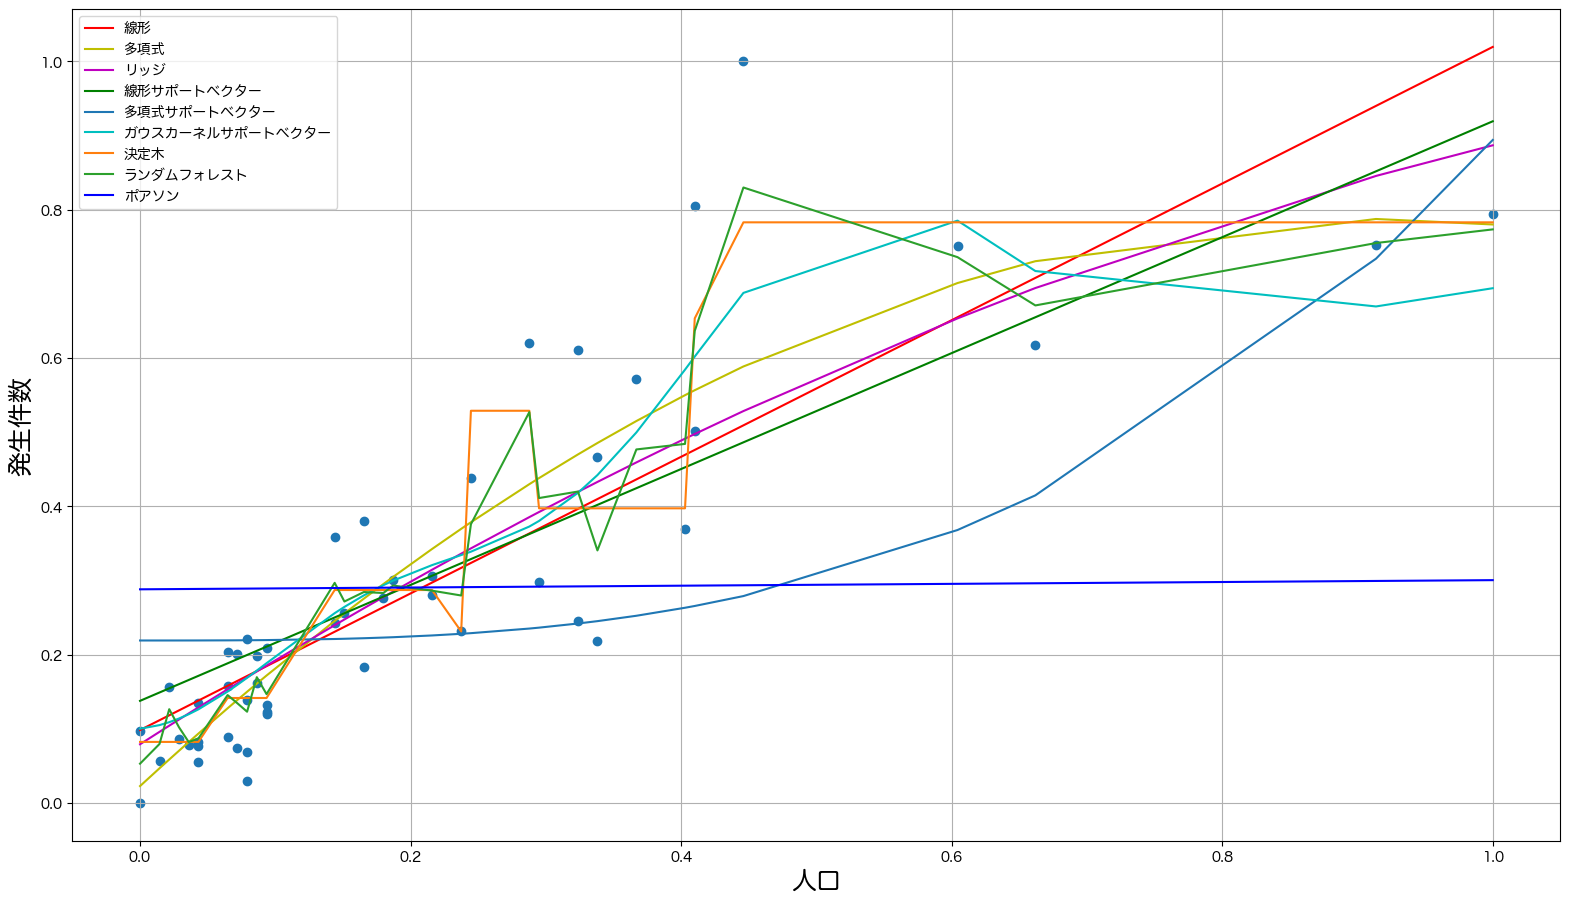

In [46]:
%matplotlib inline
plt.scatter(x,y)
plt.xlabel("発生件数",fontsize=18)
plt.ylabel("人口",fontsize=18)
plt.plot(x,linear_pred,c="r",label="線形")
plt.plot(x,poly_pred,c="y",label="多項式")
plt.plot(x,ridge_pred,c="m",label="リッジ")
plt.plot(x,svr_pred,c="g",label="線形サポートベクター")
plt.plot(x,svr_poly_pred,label="多項式サポートベクター")
plt.plot(x,svr_rbf_pred,c="c",label="ガウスカーネルサポートベクター")
plt.plot(x,tree_pred,label="決定木")
plt.plot(x,rf_pred,label="ランダムフォレスト")
plt.plot(x,poisson_pred,c="b",label="ポアソン")
plt.xlabel("人口",fontsize=18)
plt.ylabel("発生件数",fontsize=18)
plt.grid()
plt.legend()
plt.show()

In [47]:
#各モデルの性能評価
from sklearn.metrics import mean_squared_error
#MSE(平均二乗誤差)
print('線形回帰　MSE: % 4f' %mean_squared_error(y,linear_pred))
print('多項式回帰　MSE: % 4f' %mean_squared_error(y,poly_pred))
#RMSE(平均二乗平方根誤差)
print('線形回帰　RMSE: % 4f' %(np.sqrt(mean_squared_error(y,linear_pred))))
print('多項式回帰　RMSE: % 4f' %(np.sqrt(mean_squared_error(y,poly_pred))))

線形回帰　MSE:  0.016009
多項式回帰　MSE:  0.012089
線形回帰　RMSE:  0.126527
多項式回帰　RMSE:  0.109951


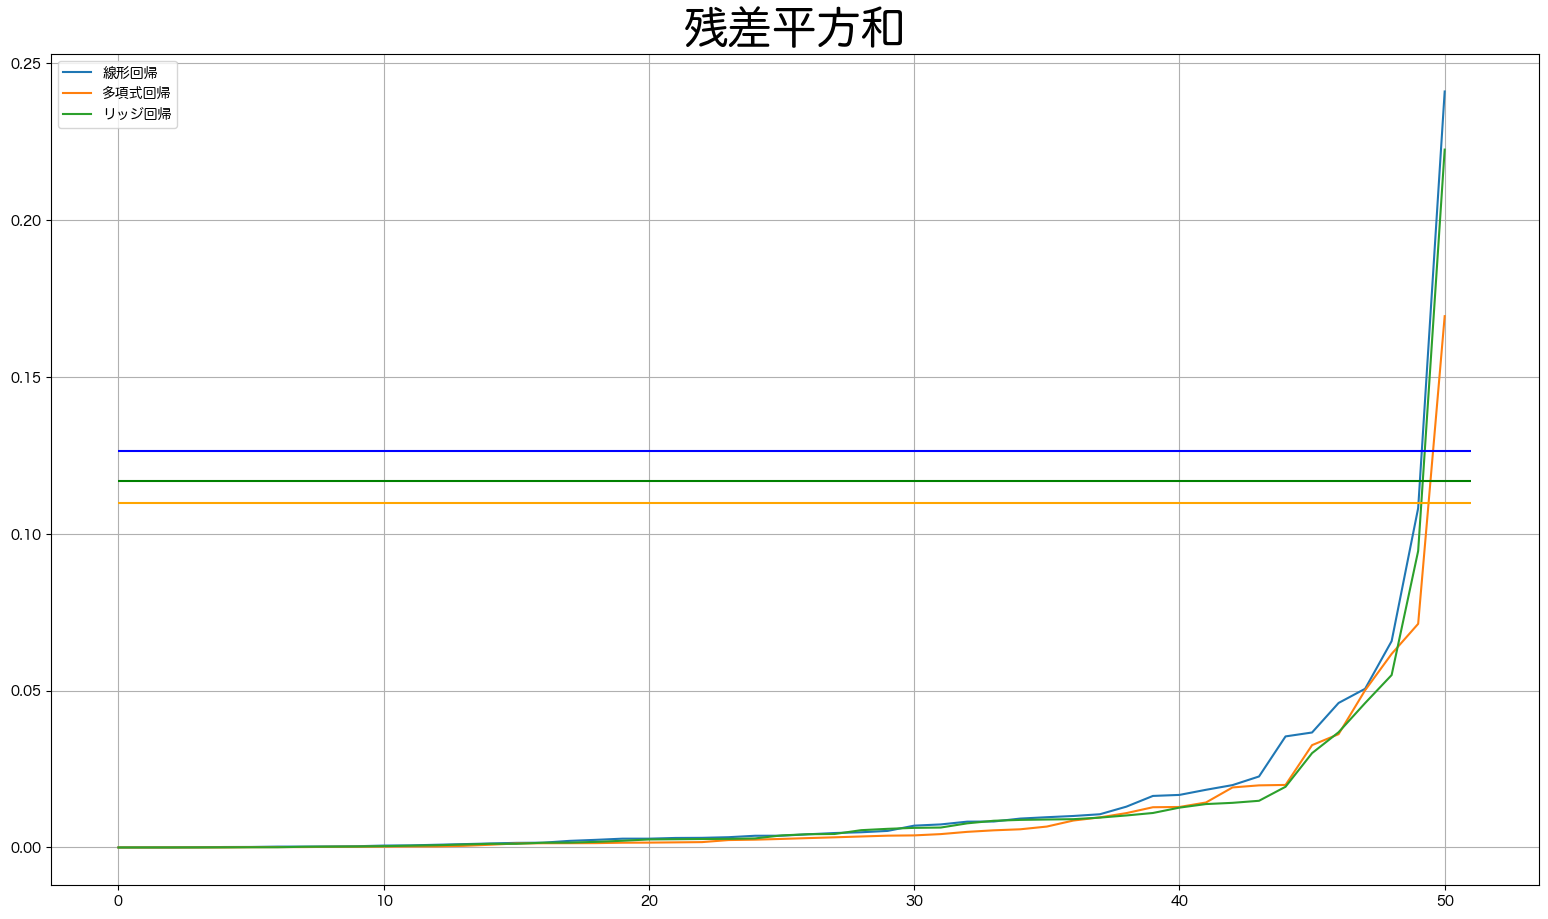

In [48]:
#残差平方和プロット
linear_e=(y-linear_pred)**2
poly_e=(y-poly_pred)**2
ridge_e=(y-ridge_pred)**2
plt.plot(np.sort((linear_e).ravel()),label="線形回帰")
plt.plot(np.sort((poly_e).ravel()),label="多項式回帰")
plt.plot(np.sort((ridge_e).ravel()),label="リッジ回帰")
plt.hlines(y=np.sqrt(mean_squared_error(y,linear_pred)),xmin=0,xmax=51,color="blue")
plt.hlines(y=np.sqrt(mean_squared_error(y,poly_pred)),xmin=0,xmax=51,color="orange")
plt.hlines(y=np.sqrt(mean_squared_error(y,ridge_pred)),xmin=0,xmax=51,color="green")
plt.title("残差平方和",fontsize=32)
plt.grid()
plt.legend()
plt.show()

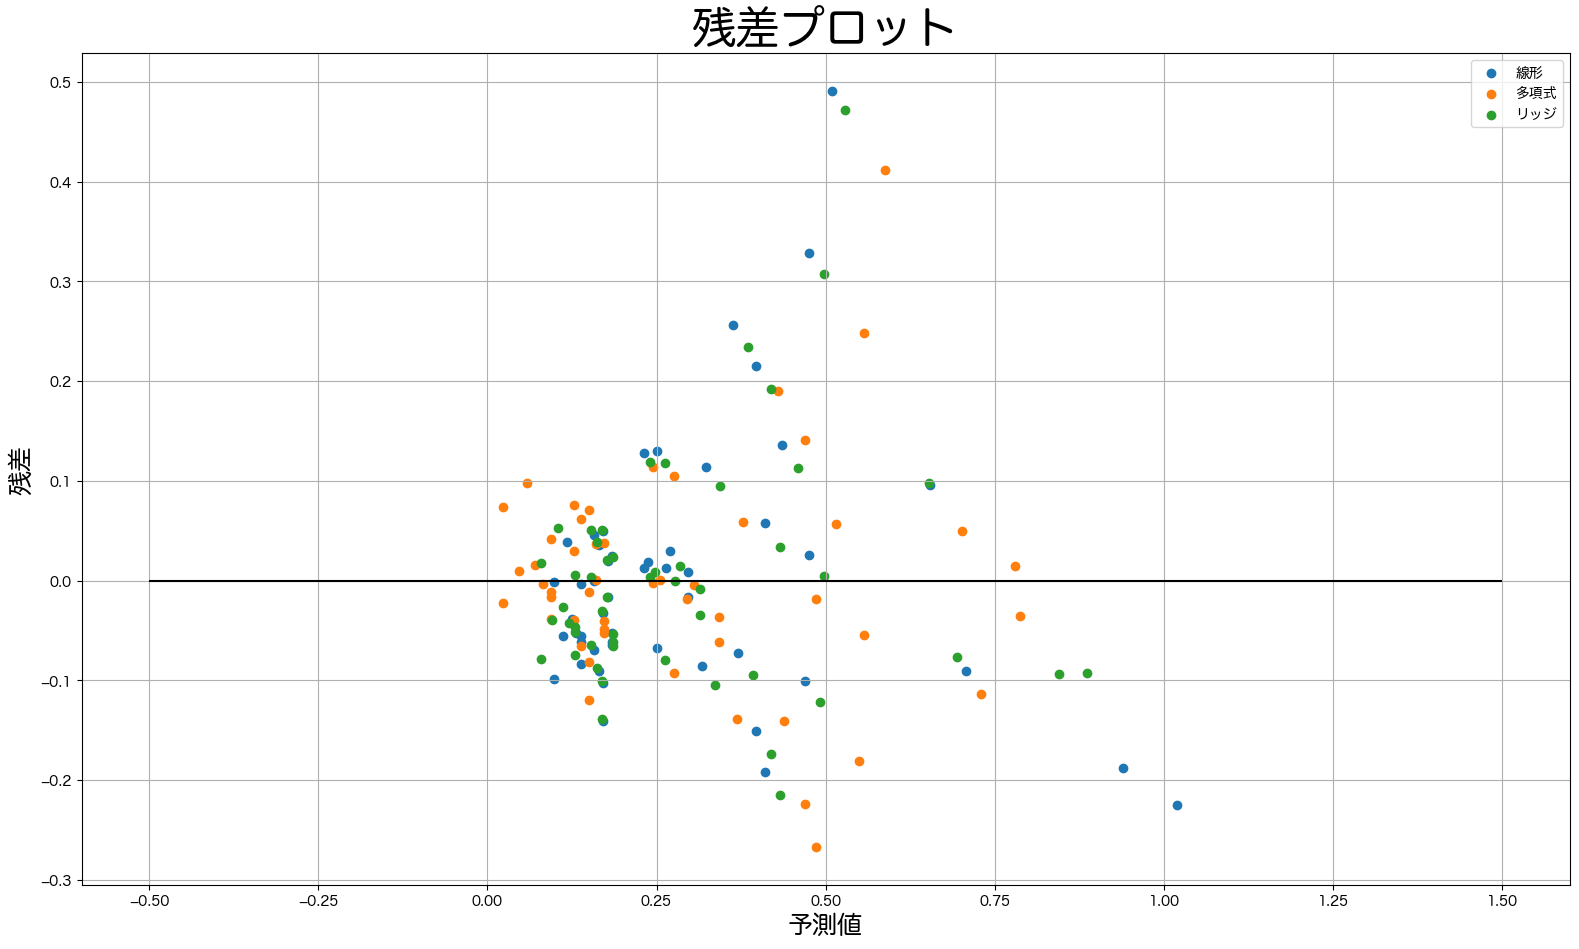

In [49]:
#残差プロット(線形回帰、多項式、リッジ)
plt.scatter(linear_pred,y-linear_pred,label="線形")
plt.scatter(poly_pred,y-poly_pred,label="多項式")
plt.scatter(ridge_pred,y-ridge_pred,label="リッジ")
plt.title("残差プロット",fontsize=32)
plt.xlabel("予測値",fontsize=18)
plt.ylabel("残差",fontsize=18)
plt.hlines(y=0,xmin=-0.5,xmax=1.5,color="black")
plt.grid()
plt.legend()
plt.show()